In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Downloading the CNN/DailyMail dataset for Text Summarization

In [ ]:
!pip install datasets
import datasets
dataset = datasets.load_dataset("ccdv/cnn_dailymail", '3.0.0')

In [4]:
import pandas as pd
import numpy as np
import nltk
import os
nltk.download(['wordnet','punkt','stopwords'])
!pip install rouge-score
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from tqdm import tqdm
tqdm.pandas()
import pickle
from collections import Counter, OrderedDict
!pip install torchtext --extra-index-url https://download.pytorch.org/whl/cu111 --upgrade
!python -m spacy download en_core_web_sm
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence

load = True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu111
     |████████████████████████████████| 10.4 MB 9.8 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

## Cleaning and saving data

We apply a very limited pre processing of the data. Basically, we only replace the line breaks with dots (to separate sentences).

In [3]:
def get_stopwords(add_words=[], keep_words=[]):
    stopwords = set()
    stopwords = stopwords.union( set(nltk.corpus.stopwords.words('english')) )
    stopwords = stopwords.union(add_words)
    stopwords = list(set(stopwords) - set(keep_words))
    return sorted(list(set(stopwords)))

def clean_text(txt):

  ## Clean 
  ### separate sentences with '. '
  txt = txt.replace('\n',' . ')
  txt = txt.replace(' .','.')
  txt = txt.replace('..','.')
  ### strip
  txt = " ".join([word.strip() for word in txt.split()])
  return txt

def preprocess_texts(df, column):
    dfc = df.copy()
    ## apply preprocess
    dfc[column+'_cleaned'] = dfc[column].progress_apply(lambda x: clean_text(x))
    
    ## residuals
    dfc["check"] = dfc[column+'_cleaned'].progress_apply(lambda x: len(x))
    if dfc["check"].min() == 0:
        print(f"There is {len(dfc[dfc['check']==0])} nans")
        dfc = dfc[dfc["check"]>0] 
            
    return dfc.drop("check", axis=1)

In [ ]:

train_data = [dic for dic in dataset["train"]]
df_train = pd.DataFrame(train_data).rename(columns={"article":"text", "highlights":"y"})[["text","y"]]

valid_data = [dic for dic in dataset["validation"]]
df_valid = pd.DataFrame(valid_data).rename(columns={"article":"text", "highlights":"y"})[["text","y"]]

test_data = [dic for dic in dataset["test"]]
df_test = pd.DataFrame(test_data).rename(columns={"article":"text", "highlights":"y"})[["text","y"]]


In [ ]:
df_train = preprocess_texts(df_train, 'text')
df_train = preprocess_texts(df_train, 'y')
df_train.to_csv('/content/gdrive/MyDrive/NLP/train.csv')

df_valid = preprocess_texts(df_valid, 'text')
df_valid = preprocess_texts(df_valid, 'y')
df_valid.to_csv('/content/gdrive/MyDrive/NLP/valid.csv')

df_test = preprocess_texts(df_test, 'text')
df_test = preprocess_texts(df_test, 'y')
df_test.to_csv('/content/gdrive/MyDrive/NLP/test.csv')

100%|██████████| 13368/13368 [00:00<00:00, 351246.36it/s]


In [ ]:
print('Full Text (RAW)')
print(df_train['text'][0],'\n')
print('Summary (RAW)')
print(df_train['y'][0],'\n')

Full Text (RAW)
It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It's a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but be

In [ ]:
print('Full Text (Cleaned)')
print(df_train['text_cleaned'][0],'\n')
print('Summary (Cleaned)')
print(df_train['y_cleaned'][0],'\n')

Full Text (Cleaned)
It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It's a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- bu

## Data Exploration

In [33]:
df_train.head()

,Unnamed: 0,text,y,text_cleaned,y_cleaned
0,0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...
1,1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...
2,2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...
3,3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...
4,4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...


#### Word and Sentence Counts

In [ ]:
def get_word_sent_counts(df):
    """Calculates number of words and sentences in the given corpus"""
    tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
    
    df['word_count_text'] = df['text_cleaned'].progress_apply(lambda x: len(tokenizer(str(x))) )
    df['sentence_count_text'] = df['text_cleaned'].progress_apply(lambda x: len(nltk.sent_tokenize(str(x))) )

    df['word_count_y'] = df['y_cleaned'].progress_apply(lambda x: len(tokenizer(str(x))) )
    df['sentence_count_y'] = df['y_cleaned'].progress_apply(lambda x: len(nltk.sent_tokenize(str(x))) )

    return df

print('Tokenizing train data ....')
counts_train = get_word_sent_counts(df_train)
print('Tokenizing validation data ....')
counts_valid = get_word_sent_counts(df_valid)
print('Tokenizing test data ....')
counts_test = get_word_sent_counts(df_test)


In [ ]:
features = counts_train.columns[-4:]
counts_train[features].to_csv('/content/gdrive/MyDrive/NLP/train_counts.csv', index = False)
counts_valid[features].to_csv('/content/gdrive/MyDrive/NLP/valid_counts.csv', index = False)
counts_test[features].to_csv('/content/gdrive/MyDrive/NLP/test_counts.csv', index = False)


In [6]:
counts_train = pd.read_csv('/content/gdrive/MyDrive/NLP/train_counts.csv')
counts_valid = pd.read_csv('/content/gdrive/MyDrive/NLP/valid_counts.csv')
counts_test = pd.read_csv('/content/gdrive/MyDrive/NLP/test_counts.csv')

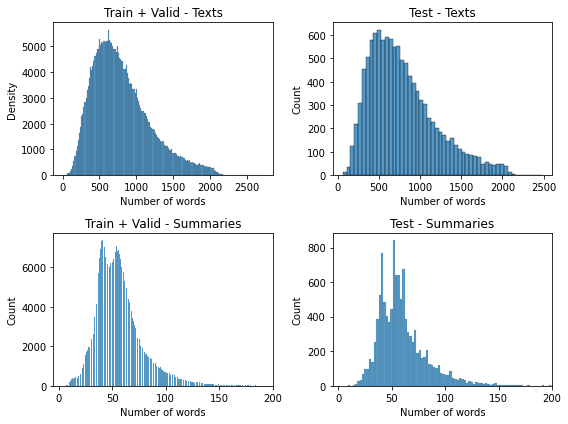

In [19]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6))

sns.histplot(counts_train['word_count_text'].append(counts_valid['word_count_text']), ax =ax[0,0])
ax[0,0].set_title('Train + Valid - Texts')
sns.histplot(counts_test['word_count_text'], ax =ax[0,1])
ax[0,1].set_title('Test - Texts')

sns.histplot(counts_train['word_count_y'].append(counts_valid['word_count_y']), ax =ax[1,0])
ax[1,0].set_title('Train + Valid - Summaries')
ax[1,0].set_xlim(-5, 200)

sns.histplot(counts_test['word_count_y'], ax =ax[1,1])
ax[1,1].set_title('Test - Summaries')

ax[1,1].set_xlim(-5, 200)
ax[0,0].set_ylabel('Density')
ax[0,0].set_xlabel('Number of words')
ax[0,1].set_xlabel('Number of words')
ax[1,0].set_xlabel('Number of words')
ax[1,1].set_xlabel('Number of words')
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/NLP/words_plot.png', dpi = 600)

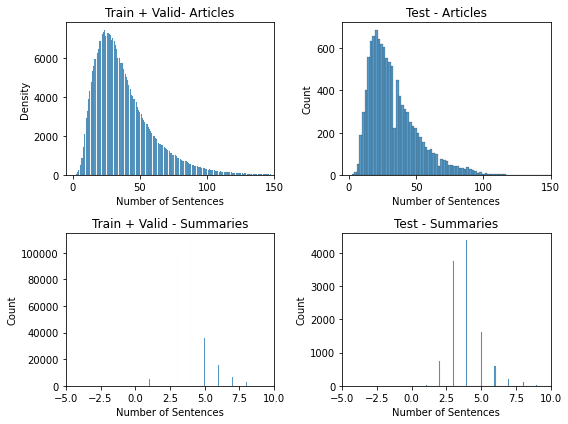

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6))

sns.histplot(counts_train['sentence_count_text'].append(counts_valid['sentence_count_text']), ax =ax[0,0])
ax[0,0].set_title('Train + Valid- Articles')
ax[0,0].set_xlim(-5, 150)

sns.histplot(counts_test['sentence_count_text'], ax =ax[0,1])
ax[0,1].set_title('Test - Articles')
ax[0,1].set_xlim(-5, 150)

sns.histplot(counts_train['sentence_count_y'].append(counts_valid['sentence_count_y']), ax =ax[1,0])
ax[1,0].set_title('Train + Valid - Summaries')

sns.histplot(counts_test['sentence_count_y'], ax =ax[1,1])
ax[1,0].set_xlim(-5, 10)
ax[1,1].set_title('Test - Summaries')

ax[1,1].set_xlim(-5, 10)
ax[0,0].set_ylabel('Density')
ax[1,0].set_xlabel('Number of Sentences')
ax[1,1].set_xlabel('Number of Sentences')
ax[0,0].set_xlabel('Number of Sentences')
ax[0,1].set_xlabel('Number of Sentences')
plt.tight_layout()
plt.savefig("/content/gdrive/MyDrive/NLP/sentence_plot.png", dpi = 600)

In [32]:
mean_words_tr_val = counts_train['word_count_text'].append(counts_valid['word_count_text']).mean()
mean_words_test = counts_test['word_count_text'].mean()
mean_words_tr_val_sum = counts_train['word_count_y'].append(counts_valid['word_count_y']).mean()
mean_words_test_sum = counts_test['word_count_y'].mean()

mean_sent_tr_val = counts_train['sentence_count_text'].append(counts_valid['sentence_count_text']).mean()
mean_sent_test = counts_test['sentence_count_text'].mean()
mean_sent_tr_val_sum = counts_train['sentence_count_y'].append(counts_valid['sentence_count_y']).mean()
mean_sent_test_sum = counts_test['sentence_count_y'].mean()

res_table = pd.DataFrame({
    '# documents' : [(counts_train.shape[0], counts_valid.shape[0]), counts_test.shape[0]],
    'avg # words in article' : [round(mean_words_tr_val,2), round(mean_words_test,2)], 
    'avg # sent in article' : [round(mean_sent_tr_val,2), round(mean_sent_test,2)],
    'avg # words in summary' : [round(mean_words_tr_val_sum,2), round(mean_words_test_sum,2)], 
    'avg # sent in summary' : [round(mean_sent_tr_val_sum,2), round(mean_sent_test_sum,2)]
}, index = ['Train + Valid', 'Test'])
res_table.T

,# documents,avg # words in article,avg # sent in article,avg # words in summary,avg # sent in summary
Train + Valid,"(287113, 13368)",802.84,38.57,56.78,3.84
Test,11490,791.39,33.33,59.81,3.92


In [33]:
print(res_table.T.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &      \# documents &  avg \# words in article &  avg \# sent in article &  avg \# words in summary &  avg \# sent in summary \\
\midrule
Train + Valid &  (287113, 13368) &                  802.84 &                  38.57 &                   56.78 &                   3.84 \\
Test          &            11490 &                  791.39 &                  33.33 &                   59.81 &                   3.92 \\
\bottomrule
\end{tabular}



## Lead-3 Baseline (extractive)


In [ ]:
if load: 
  #Loading if not already in memory
  df_test = pd.read_csv('/content/gdrive/MyDrive/NLP/test.csv')

In [43]:
def get_rouge_scores(predicted_summaries, target_summaries) : 
    """Calculates rouge scores based on the rouge_score package. 
    Predicted and target summaries are expected to have a "\n" sentence separator.

    Inputs:
    predicted_summaries: list of str. List containing the predicted summaries
    target_summaries: list of str. List containing the true summaries

    Returns:
    result_dic: dict. Dictionary containing rouge1, rouge2 and rougeLsum as keys and 
                      list of scores per summary as values.
    """
    result_dic = {'rouge1' : [], 'rouge2' : [], 'rougeLsum': []}
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)
    for sum_hat, sum_true in tqdm(zip(predicted_summaries, target_summaries), total = len(predicted_summaries)) : 
      score = scorer.score(sum_hat,sum_true)
      for score_name in result_dic.keys() : 
        result_dic[score_name].append(score[score_name].fmeasure)
    return result_dic

The lead-3 baseline takes the first 3 sentences of an article as a summary. [A.See & al](https://arxiv.org/pdf/1704.04368.pdf) have shown that this baseline model produces a really good ROUGE score that even their Seq2Seq models could not outperform. They argue that ROUGE actually favors extractive summary systems rather than abstractive systems (such as Seq2Seq models). 

We will build the lead-3 baseline and compare it to our Seq2Seq system.

In [4]:
from nltk.tokenize import sent_tokenize

def lead3_summaries(corpus) : 
  """Performs Lead-3 baseline based on original corpus. 
  Takes the first 3 sentences and separate them with a "\n". """
  return corpus.progress_apply(lambda x: "\n".join(sent_tokenize(x)[:3]))

In [ ]:
lead3_sum = lead3_summaries(df_test['text'])

100%|██████████| 11490/11490 [00:15<00:00, 765.21it/s]


In [ ]:
lead3_scores = get_rouge_scores(lead3_sum, df_test['y'])

100%|██████████| 11490/11490 [01:57<00:00, 97.99it/s]


In [ ]:
print(f"(Lead-3) Rouge 1: {np.mean(lead3_scores['rouge1']):0.3f}")
print(f"(Lead-3) Rouge 2: {np.mean(lead3_scores['rouge2']):0.3}")
print(f"(Lead-3) Rouge L: {np.mean(lead3_scores['rougeLsum']):0.3f}")


(Lead-3) Rouge 1: 0.401
(Lead-3) Rouge 2: 0.175
(Lead-3) Rouge L: 0.363


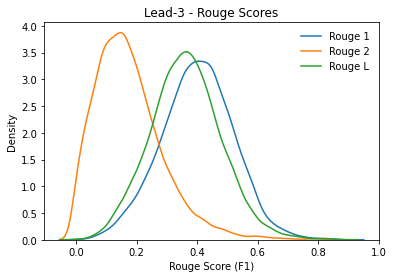

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(lead3_scores['rouge1'], label = 'Rouge 1', ax = ax)
sns.kdeplot(lead3_scores['rouge2'], label = 'Rouge 2', ax = ax)
sns.kdeplot(lead3_scores['rougeLsum'], label = 'Rouge L', ax = ax)
plt.legend(frameon = False)
plt.title('Lead-3 - Rouge Scores')
x= plt.xlabel('Rouge Score (F1)')

In [ ]:
import pickle 
with open('/content/gdrive/MyDrive/NLP/rouge_scores_lead3.pkl','wb') as f :
  pickle.dump(lead3_scores, f)
with open('/content/gdrive/MyDrive/NLP/summaries_lead3.pkl','wb') as f : 
  pickle.dump(lead3_sum,f)

## Seq2seq Transformer (abstractive)

In this section, we build a Seq2Seq model that uses Transformers in order to make predictions. We believe that using Transformers could both be an increase in performances and in training time when compared to RNN Seq2Seq models. Indeed, models using Transformers are state-of-the-art in many NLP tasks including [summarization](https://paperswithcode.com/sota/abstractive-text-summarization-on-cnn-daily). 

We follow the pre processing of [Nallapati & Al](https://arxiv.org/pdf/1602.06023.pdf): we use the most frequent $150000$ words in the articles vocabulary and the $80000$ most frequent words in the summaries vocabulary. We also set the maximum length of an article to $800$ and the maximum length of the summary to $100$ during training.

In [5]:
if load : 
    df_train = pd.read_csv('/content/gdrive/MyDrive/NLP/train.csv', usecols = ['text_cleaned','y_cleaned'])
    df_valid = pd.read_csv('/content/gdrive/MyDrive/NLP/valid.csv', usecols = ['text_cleaned','y_cleaned'])
    df_test = pd.read_csv('/content/gdrive/MyDrive/NLP/test.csv', usecols = ['text_cleaned', 'y'])

### Vocabulary & Dataloaders

In [6]:
if load : 
  text_vocab = torch.load( '/content/gdrive/MyDrive/NLP/text_vocab.pth.tar')
  text_tok = torch.load( '/content/gdrive/MyDrive/NLP/text_tokenizer.pth.tar')
  sum_vocab = torch.load( '/content/gdrive/MyDrive/NLP/summary_vocab.pth.tar')
  sum_tok = torch.load( '/content/gdrive/MyDrive/NLP/summary_tokenizer.pth.tar')
  SOS_IDX, EOS_IDX, PAD_IDX = text_vocab['<sos>'], text_vocab['<eos>'], text_vocab['<pad>']

In [7]:
def build_vocab(corpus, max_words = 150000):
  """Build a PyTorch Vocab object based on the given corpus. Texts are supposed to be written in english.
  The vocabulary is built using spacy english tokenizer.
  Inputs:
    corpus: list or pd.Series. Iterator containing the texts.
    max_words: int. Specifies the number of most frequent words to keep in the vocabulary.
  
  Returns:
    voc_dic: Vocab object containing the vocabulary of the given corpus.
    tokenizer: Trained spacy tokenizer.
  """
  counter = Counter()
  tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
  for text in tqdm(corpus):
      counter.update(tokenizer(text))
  sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:max_words]
  ordered_dict = OrderedDict(sorted_by_freq_tuples)

  voc_dic = vocab(ordered_dict, specials=['<unk>', '<pad>', '<sos>', '<eos>'])
  voc_dic.set_default_index(voc_dic['<unk>'])
  global SOS_IDX, EOS_IDX, PAD_IDX
  SOS_IDX = voc_dic['<sos>']
  EOS_IDX = voc_dic['<eos>']
  PAD_IDX = voc_dic['<pad>']

  return voc_dic, tokenizer


def sequential_transforms(*transforms):
    """Creates a serie of transformation function that takes as input a sequence of tokens"""
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func


def tensor_transform(tokens, maxlen = 100000):
    """Adds a SOS token at the beggining of the sequence and a EOS token at the end of the sequence.
    The sequence is then converted to Tensor. Only the first `maxlen` tokens are kept."""
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(tokens)[:maxlen],
                      torch.tensor([EOS_IDX])))

def collate_fn(batch):
    """Function that will be used on each batch created by a Pytorch DataLoader.
     Performs transformation of each pair of (article, summary) in the batch. 
     Transformations includes: tokenization -> convert to ids -> tensor transform.
     In the end, pad the sequences to the length of the longest sequence in the batch with the PAD_IDX token.
    """
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(transforms["text"](src_sample.rstrip("\n")))
        
        tgt_batch.append(transforms["sum"](tgt_sample.rstrip("\n")) if tgt_sample is not None else None)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX) if tgt_sample is not None else None
    return src_batch, tgt_batch

In [ ]:
### CREATION OF THE ARTICLES VOCABULARY
text_vocab, text_tok = build_vocab(df_train['text_cleaned'], max_words = 150000)

In [ ]:
### CREATION OF THE SUMMARIES VOCABULARY
sum_vocab, sum_tok = build_vocab(df_train['y_cleaned'], max_words = 80000)

In [9]:
### SAVING VOCABULARIES AND TOKENIZERS FOR LATER USES
torch.save(text_vocab, '/content/gdrive/MyDrive/NLP/text_vocab.pth.tar')
torch.save(text_tok, '/content/gdrive/MyDrive/NLP/text_tokenizer.pth.tar')
torch.save(sum_vocab, '/content/gdrive/MyDrive/NLP/summary_vocab.pth.tar')
torch.save(sum_tok, '/content/gdrive/MyDrive/NLP/summary_tokenizer.pth.tar')

In [8]:
### BUILDING SEQUENTIAL TRANSFORM FUNCTIONS
from functools import partial

# The articles max length is 800 tokens
text_tens_trans = partial(tensor_transform, maxlen = 800)

# The summaries max length is 100 tokens
sum_tens_trans = partial(tensor_transform, maxlen = 100)

transforms = {}

# Tokenization -> Convert to Ids -> Add SOS + EOS and convert to Tensor
transforms['text'] = sequential_transforms(text_tok, text_vocab, text_tens_trans)
transforms['sum'] = sequential_transforms(sum_tok, sum_vocab, sum_tens_trans)


In [9]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
class TextDataset(Dataset):
    """A very simple PyTorch dataset that reads in-memory texts and summaries."""
    def __init__(self, texts, summaries) :
      self.texts = texts 
      self.summaries = summaries
      
    def __len__(self) : 
      return len(self.texts)
      
    def __getitem__(self, index) : 

      text = self.texts[index]
      
      summary =  self.summaries[index] if self.summaries is not None else None
                           
      return text, summary

In [10]:
## Building Datasets and Dataloaders

trainset = TextDataset(df_train['text_cleaned'], df_train['y_cleaned'])
valset = TextDataset(df_valid['text_cleaned'], df_valid['y_cleaned'])
testset = TextDataset(df_test['text_cleaned'], None)

train_loader = DataLoader(trainset, batch_size = 16, shuffle = True, num_workers = 0, collate_fn=collate_fn)
val_loader = DataLoader(valset, batch_size = 16, shuffle = False, num_workers = 0, collate_fn=collate_fn)
test_loader = DataLoader(testset, batch_size = 16, shuffle = False, num_workers = 0, collate_fn=collate_fn)

### Pytorch Transformer Model

Code is adapted from PyTorch's [tutorial](https://pytorch.org/tutorials/beginner/translation_transformer.html) on Seq2Seq Transformers for language translation. We adapted it to the summarization task.

In [11]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
from queue import PriorityQueue
import operator


# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.emb_size = emb_size
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
      
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


### Training utils

In [13]:
def train_epoch(model, optimizer, epoch_num, loss_fn):

    losses = 0
    pbar = tqdm(enumerate(train_loader), desc = f'loss', total = len(train_loader))
    model.train()
    for idx, (src, tgt) in pbar : 
        #We need to put model in train mode at each iteration as the translation puts it in eval mode

        #Adjusting learning rate based on transformer paper scheme
        step_num = len(train_loader) * epoch_num + idx +1 
        optimizer.param_groups[0]['lr'] = adjust_lr(transformer.emb_size, 10000, step_num)
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        del logits, tgt_out, src, tgt, tgt_input, src_mask, src_padding_mask, tgt_mask, tgt_padding_mask
        loss.backward()

        optimizer.step()
        losses += loss.item()
        pbar.set_description(f'Loss {losses / (idx+1)}')

    return losses / len(train_loader)

def evaluate(model, loss_fn):
    model.eval()
    losses = 0
    pbar = tqdm(enumerate(val_loader), desc = f'loss', total = len(val_loader))

    for idx, (src, tgt) in pbar:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        pbar.set_description(f'Loss {losses / (idx+1)}')

    return losses / len(val_loader)

def adjust_lr(d_model, warmup_steps, step) : 
    """Learning rate scheme from Text Summarization with Pretrained Encoders"""
    return (d_model**-0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
     

### Decoding utils

We build two decoding strategies: Greedy and Beam Search.

#### Greedy decoding

Greedy decoding simply uses the most likely token at each decoding time (hence the name greedy).


In [14]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    memory = memory.to(DEVICE)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    conditional_prob = 0
    for i in range(max_len-1):
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        val, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        conditional_prob += val
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys, conditional_prob / ys.size(0)

def greedy_summarize(model: torch.nn.Module, src_sentence: str, maxlen = 100):
    with torch.no_grad() : 
      model.eval()
      src = transforms['text'](src_sentence).view(-1, 1)
      num_tokens = src.shape[0]
      src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
      tgt_tokens, contional_prob = greedy_decode(
          model,  src, src_mask, max_len=maxlen, start_symbol=SOS_IDX)
      return " ".join(sum_vocab.lookup_tokens(list(tgt_tokens.flatten().cpu().numpy()))).replace("<sos>", "").replace("<eos>", "").strip()


#### Beam-Search decoding

Beam Search decoding maintains a queue of top $K$ most likely tokens at each decoding time and expands the queue with top $K$ most likely tokens whenever a decoding happens. 

It results in a very large number of trials, and the sequence with the highest log likelihood is returned. 

In practice, we limit the number of iterations as we don't have enough computation power to try all the combinations.

The code is adapted from this [github](https://github.com/budzianowski/PyTorch-Beam-Search-Decoding/blob/master/decode_beam.py), which builds beam search for Seq2Seq-RNN models. We adapted it to match a Seq2Seq Transformer model and optimized it by putting a max length restriction as well as a max number of iterations.

In [87]:
## Package to build a priority queue in Python
from heapq import * 

class BeamSearchNode(object):
    def __init__(self, previousNode, ys, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.prevNode = previousNode
        self.ys = ys
        self.logp = logProb
        self.leng = length
        
    def eval(self, alpha = 1):

        return self.logp / (float(self.leng)**alpha)

    def wordid(self) : 
      return self.ys[-1].item()


def beam_decode(model, src, src_mask, beam_width= 5, max_len = 100, max_iter = 2000):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :return: decoded_batch
    '''

    topk = 1  # how many sentence do you want to generate
    decoded_batch = []

    # decoding goes sentence by sentence
    for idx in range(src.size(1)):
        src = src.to(DEVICE)
        src_mask = src_mask.to(DEVICE)

        memory = model.encode(src, src_mask)

        # Start with the start of the sentence token
        ys = torch.ones(1, 1).fill_(SOS_IDX).type(torch.long).to(DEVICE)

        # Number of sentence to generate
        endnodes = []
        number_required = min((topk + 1), topk - len(endnodes))

        # starting node -  hidden vector, previous node, word id, logp, length
        node = BeamSearchNode(None, ys, 0, 1)
        queue = []

        # start the queue
        heappush(queue, (-node.eval(), node))
        n_iter = 1
        done = False
        # start beam search
        while not done :
            # give up when decoding takes too long
            if n_iter >= max_iter : done = True
            # fetch the best node
            score, n = heappop(queue)
            while n.leng >= max_len : 
              endnodes.append((score,n))
              if len(queue) == 0 : 
                  done = True
              score, n = heappop(queue)

            ys = n.ys
            if n.wordid() == EOS_IDX and n.prevNode != None:
                endnodes.append((score, n))
                # if we reached maximum # of sentences required
                if len(endnodes) >= number_required:
                    done = True

            # decode for one step using decoder
            tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                .type(torch.bool)).to(DEVICE)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])

            # PUT HERE REAL BEAM SEARCH OF TOP
            log_prob, indexes = torch.topk(prob, beam_width)
            nextnodes = []

            for new_k in range(beam_width):
                decoded_t = indexes[0][new_k].view(1, -1)
                log_p = log_prob[0][new_k].item()
                next_ys = torch.cat([n.ys, torch.ones(1, 1).type_as(src.data).fill_(decoded_t.item())], dim=0)
                node = BeamSearchNode(n, next_ys, n.logp + log_p, n.leng + 1)
                score = -node.eval()
                #put them into queue
                heappush(queue, (score, node))
            n_iter +=1
        # choose nbest paths, back trace them
        if len(endnodes) == 0:
            endnodes = [heappop(queue) for _ in range(topk)]
        utterances = []
        for score, n in sorted(endnodes, key=operator.itemgetter(0)):
            utterance = []
            utterance.append(n.wordid())
            # back trace
            while n.prevNode != None:
                n = n.prevNode
                utterance.append(n.wordid())

            utterance = utterance[::-1]
            utterances.append(utterance)
                        
        decoded_batch.append(utterances)
    return decoded_batch


def beam_summarize(model: torch.nn.Module, src_sentence: str, max_len = 100, beam_width = 4, max_iter = 2000):
    with torch.no_grad() :
      model.eval()
      src = transforms['text'](src_sentence).view(-1, 1)
      num_tokens = src.shape[0]
      src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
      beam_decoding = beam_decode(
          model,  src, src_mask, max_len=max_len, beam_width = beam_width, max_iter = max_iter)
      highest_prob_decoding = beam_decoding[0][0]
      return " ".join(sum_vocab.lookup_tokens(highest_prob_decoding)).replace("<sos>", "").replace("<eos>", "").strip()


### Training

In [27]:
del transformer
torch.cuda.empty_cache()
import gc
gc.collect()

1945

In [17]:

SRC_VOCAB_SIZE = len(text_vocab)
TGT_VOCAB_SIZE = len(sum_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 2048
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)


transformer = transformer.to(DEVICE)
if load : 
  checkpoint = torch.load(f'/content/gdrive/MyDrive/NLP/transformer_emb{EMB_SIZE}_ffn{FFN_HID_DIM}_h{NHEAD}_nenco{NUM_ENCODER_LAYERS}_ndeco{NUM_DECODER_LAYERS}.pth.tar')
  transformer.load_state_dict(checkpoint['model_state_dict'])

training_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
validation_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), betas=(0.9, 0.98))


In [29]:
print('Number of trainable parameters:')
print(f'{sum([len(i.ravel()) for i in transformer.parameters() if i.requires_grad]):,}')

Number of trainable parameters:
173,521,028


In [ ]:
NUM_EPOCHS = 20
best_val_loss = 1000000
all_train_losses = []
all_val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    train_loss = train_epoch(transformer, optimizer, epoch, training_loss_fn)
    val_loss = evaluate(transformer, validation_loss_fn)

    all_train_losses.append(train_loss)
    all_val_losses.append(val_loss)
    ## Logging summarization along training process
    with torch.no_grad() : 
      test_idx = np.random.randint(len(df_valid[:100]))
      print("Beam Search\n", beam_summarize(transformer, valset[test_idx][0], max_iter=2000))
      print("Greedy Search\n", greedy_summarize(transformer, valset[test_idx][0]))
      print(valset[test_idx][1])
    ## This is just to make sure that we don't loose the losses if colab disconnects 
    ## as resuming training is possible since we save the model at each epoch
    with open('/content/gdrive/MyDrive/NLP/train_losses.pkl','wb') as f :
        pickle.dump(all_train_losses, f)
    with open('/content/gdrive/MyDrive/NLP/validation_losses.pkl','wb') as f :
        pickle.dump(all_val_losses, f)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}"))
    if val_loss < best_val_loss : 
      best_val_loss = val_loss 
      torch.save({
          'epoch': epoch,
          'model_state_dict': transformer.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
      }, f'/content/gdrive/MyDrive/NLP/transformer_emb{EMB_SIZE}_ffn{FFN_HID_DIM}_h{NHEAD}_nenco{NUM_ENCODER_LAYERS}_ndeco{NUM_DECODER_LAYERS}.pth.tar')
    elif epoch > 0 : 
      break 


Loss 5.288801635281321: 100%|██████████| 836/836 [02:27<00:00,  5.67it/s]


Beam Search
 The virus is a virus in the U.S. and the U.S. are not known . The virus is the first to be used to be used in the U.S. to be used in the U.S. to be used in the U.S. .
Greedy Search
 The virus is a virus in the U.S. , the U.S. and the U.S. are not known . The virus is a virus is a patient and the virus . The virus is a new virus . The virus is a new report says the virus is not a problem .
External advisory committee to CDC warns the agency is on its way to losing credibility. Group of experts says CDC's commitment to safety is "inconsistent" and "insufficient ". Advisory committee recommends all CDC labs go through external review and accreditation process.
Epoch: 1, Train loss: 5.861, Validation loss: 5.289


Loss 5.03041217629419: 100%|██████████| 836/836 [02:30<00:00,  5.56it/s]


Beam Search
 NEW : The plane had been in a flight to the plane . The flight was a flight from a flight to France to France . The flight to France to France to France to France . The flight from France to France to France to France to France .
Greedy Search
 NEW : The flight was a flight to a flight to the flight . The flight was a flight to the flight to the flight from the plane . The flight to the plane was a flight to the plane was a flight . The flight to the plane was a flight to the plane was a flight .
Andreas Lubitz had informed his Lufthansa training school of an episode of severe depression, airline says. A police spokesman say reports about video found in Germanwings wreckage are "completely wrong". Journalists at Bild and Paris Match are "very confident" the video clip is real, an editor says.
Epoch: 2, Train loss: 5.348, Validation loss: 5.030


Loss 4.979604059999639: 100%|██████████| 836/836 [02:27<00:00,  5.68it/s]


Beam Search
 NEW : The plane 's plane was flying from the air . NEW : The plane 's brother says it 's a plane was a plane was a plane . NEW : The plane was carrying a plane was carrying a plane landed in the air traffic control of the air traffic . The plane 's plane 's plane was flying from the air traffic control . The plane was flying from the air traffic control .
Greedy Search
 NEW : The plane was flying from the air traffic control of the air . NEW : The plane was flying from the plane was flying from the plane was flying from the air . NEW : The plane was flying from the plane was flying from the plane was flying from the air . The plane was flying from the plane was flying from the air . The plane was flying from the plane was flying from the plane was flying from the air . The plane was flying from the plane was flying from the plane was
LaGuardia Airport's Runway 13 reopens after plane removed. Passenger: Airplane skidded for about 20 seconds before stopping feet from water. 

Loss 4.9384205683566735: 100%|██████████| 836/836 [02:26<00:00,  5.69it/s]


Beam Search
 The teen was arrested on suspicion of conspiracy . The two other teens were on Friday . The teen 's flight from Turkey .
Greedy Search
 The teen , 18 , and 16 , were arrested on suspicion of conspiracy to commit to Syria . The teen was arrested on suspicion of conspiracy to commit to Syria . The teen 's flight from Turkey .
Three teens were released on bail in London, where they face terror charges. Three males -- two of them 17, one of them 19 -- detained by Turkish authorities, police say.
Epoch: 4, Train loss: 5.197, Validation loss: 4.938


Loss 4.884839981651762: 100%|██████████| 836/836 [02:27<00:00,  5.68it/s]


Beam Search
 Davis : " I 'm not a lot of the world " . Davis : " I 'm not racist " Davis : " I 'm not racist " . Davis : " Davis : " I 'm not racist "
Greedy Search
 Davis : Davis ' We 're not racist ' . Davis : Davis , Davis : Davis : Davis should be a lot of girls should be a " . She says Davis : Davis : Davis : Davis should be a lot of girls should be a lot of girls should be a "
Roxanne Jones: Ballplayer called Mo'ne Davis slut in a tweet. She graciously asked his college to reinstate him after he was kicked from team. Jones: Black girls conditioned from young age by culture and even family to accept being called over-sexualized names. She says it's hurtful, confusing, can have long-term effect. Community should recognize the harm this does to young, smart, strong girls.
Epoch: 5, Train loss: 5.131, Validation loss: 4.885


Loss 4.845335100826464: 100%|██████████| 836/836 [02:27<00:00,  5.66it/s]


Beam Search
 The model of fashion designer <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> . The fashion designer <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> .
Greedy Search
 The model of fashion designer <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> . The pair were sent to the fashion show . The fashion designer <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> .
Dolce & Gabbana dedicated their fall fashion show to moms. Some of the models carried their own babies down the runway.
Epoch: 6, Train loss: 5.076, Validation loss: 4.845

Loss 4.814945493018228: 100%|██████████| 836/836 [02:24<00:00,  5.79it/s]


Beam Search
 John Kerry : Netanyahu 's new government is not a right - wing of the state of - run media . He says Netanyahu 's right - wing leaders are not a good idea of the U.S. government 's views on the right - wing party 's views . Netanyahu 's leadership is a right - wing party 's leadership is a right - wing party 's leadership , he says . Netanyahu 's leadership is not a right - wing party 's views .
Greedy Search
 John Kerry : Netanyahu 's comments come after a speech on the state of Israel 's election . He says Netanyahu 's views on the U.S. has been a long - term relationship with Netanyahu 's views . Netanyahu 's views on the U.S. , Netanyahu 's views on the West Bank of the West Bank . Netanyahu 's views on the West Bank of Israel 's leadership is not a political party 's leadership .
Israeli Prime Minister Benjamin Netanyahu won re-election Tuesday. Guy Ziv: Netanyahu has repeatedly injected himself into U.S. politics.
Epoch: 7, Train loss: 5.043, Validation loss: 4.815


Loss 4.792713974081158: 100%|██████████| 836/836 [02:25<00:00,  5.76it/s]


Beam Search
 The two points clear of the best players in the United States . The other players were n't able to get a free . The two points behind the two points behind the two points .
Greedy Search
 The two - time champion Sam <unk> was the first player to win the game . The two - time champion is now the first player to win the game . The two - time champion is the first player to win the game of the game .
Kentucky destroys West Virginia. Notre Dame's offense gets hot in the second half, led by Demetrius Jackson. Wisconsin holds off ACC's North Carolina with superb free-throw shooting.
Epoch: 8, Train loss: 5.012, Validation loss: 4.793


Loss 4.774529633054323: 100%|██████████| 836/836 [02:25<00:00,  5.74it/s]


Beam Search
 Nigeria 's president says he is " a great way " in the country 's military rule " in the country 's military rule " in the country 's political situation " of our country 's political situation "
Greedy Search
 Nigeria 's president says he is " a great leader . He says he is " a good thing " . He says he is " in the country 's been in the country 's most important thing " . He says he is in the country 's president .
Incumbent President Goodluck Jonathan acknowledges defeat, says he delivered on promise of fair elections. Muhammadu Buhari's party says Jonathan called to concede even before final results are announced. Buhari is a 72-year-old retired major general who ruled in Nigeria in the 1980s.
Epoch: 9, Train loss: 4.986, Validation loss: 4.775


Loss 4.76147175861888: 100%|██████████| 836/836 [02:25<00:00,  5.74it/s]


Beam Search
 The Navy 's final - class Navy is expected to be made in the U.S. Navy says it was a Navy ship in the final year of the U.S. Navy 's final film "
Greedy Search
 The Navy Navy ship was the Navy 's final film . It was the first class to be made by the Navy . The Navy 's Navy 's Navy 's Navy . The Navy Navy Navy Navy Navy Navy Navy Navy says it was a group is expected to be the Navy 's "
Aircraft carrier USS Ranger's final journey likely will take four to five months, Navy says. Ranger, which was launched in 1956, appeared in movies such as "Top Gun" and "Star Trek IV"
Epoch: 10, Train loss: 4.961, Validation loss: 4.761


Loss 4.740041467276487: 100%|██████████| 836/836 [02:22<00:00,  5.87it/s]


Beam Search
 Jay Z 's new album is a new album , but not a new album , but it 's not a new album , but it 's not a good idea , but it 's not a good idea , but it 's not a good idea , but it 's not a good idea , but it 's not a good idea , but it 's not a good time , but it 's not a good time , ' ' it 's not a good time is n't a good time is n't easy decision is n't
Greedy Search
 Jay Z 's new album is a new album . The singer has been a popular music industry since the U.S. music industry . The singer has been a new album is a popular music industry .
Swift pulled her music from Spotify last year. Jay Z bid more than $56 million for the streaming site. It's being billed as a high end streaming report.
Epoch: 11, Train loss: 4.938, Validation loss: 4.740


Loss 4.718003803463073: 100%|██████████| 836/836 [02:22<00:00,  5.86it/s]


Beam Search
 This page includes the show Transcript and the show Transcript , and and and a chance of events in a week , and a chance of events , and students with reading comprehension and and and and is a chance for a chance for students ' knowledge of events in their knowledge of events in their knowledge of events in and ' knowledge of events in their latest episode ' knowledge of events in their latest episode ' knowledge of events in a week , comment for a week , comment for a week , comment for a teacher
Greedy Search
 This page includes the show Transcript . Use the Transcript to help students with reading comprehension and vocabulary . At the bottom of the page , comment for a chance to be mentioned on CNN Student News . You must be a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a teacher or a

Loss 4.7082642351041: 100%|██████████| 836/836 [02:21<00:00,  5.89it/s]


Beam Search
 NEW says police are " very serious " in the deaths " and " are not a police official who was found on a street " police officer who was a suspect " a suspect " police officer who was a suspect " a suspect " police " a man who was a suspect " a man who was a man who was a suspect " when the children and a man who was taken away " police officer who was taken away " police officer who was taken away from her own life - threatening injuries are in
Greedy Search
 NEW : The mother of three children are dead , police say . NEW : The mother of three children are dead . NEW : The mother of the children are " a woman 's mother says she was " . NEW : The mother says she was found dead in a hospital .
Police fired "less lethal" bean bag rounds at woman with knife after she didn't comply. An autopsy set for Sunday could help determine how the children died, police say. 3 children are found unresponsive at a home in Palm Bay, on Florida's East coast.
Epoch: 13, Train loss: 4.898, Valid

Loss 4.8636628931161585:  42%|████▏     | 7560/17945 [43:13<1:00:01,  2.88it/s]

### Results

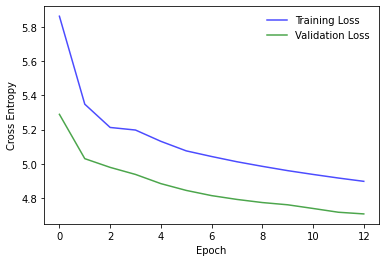

In [24]:
if load: 
    with open('/content/gdrive/MyDrive/NLP/train_losses.pkl','rb') as f :
        all_train_losses = pickle.load(f)
    with open('/content/gdrive/MyDrive/NLP/validation_losses.pkl','rb') as f :
        all_val_losses= pickle.load(f)
plt.figure(figsize = (6,4))
plt.plot(all_train_losses, label = 'Training Loss', c = 'blue', alpha = 0.7)
plt.plot(all_val_losses, label = 'Validation Loss', c = 'green', alpha = 0.7)
plt.legend(frameon = False)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.savefig('/content/gdrive/MyDrive/NLP/losses.png', dpi = 600)

In [41]:
## INFERENCE (Greedy Decode)
s2s_summaries = []
for text in tqdm(df_test['text_cleaned'] ) : 
  s2s_summaries.append(greedy_summarize(transformer,text, maxlen = 100).strip())

100%|██████████| 11490/11490 [44:00<00:00,  4.35it/s]


In [50]:
## INFERENCE (Beam Search Decode)
s2s_summaries_beam = []
for text in tqdm(df_test['text_cleaned'] ) : 
  s2s_summaries_beam.append(beam_summarize(transformer,text, max_len = 100, beam_width = 4, max_iter = 500).strip())

  0%|          | 1/11490 [00:04<15:34:45,  4.88s/it]


KeyboardInterrupt: ignored

In [44]:
## CALCULATING ROUGE SCORES ##
from nltk.tokenize import sent_tokenize

rouge_s2s_summaries = ['\n'.join(sent_tokenize(i)) for i in tqdm(s2s_summaries, total = len(s2s_summaries))]
result_s2s = get_rouge_scores(rouge_s2s_summaries, df_test['y'])

100%|██████████| 11490/11490 [01:05<00:00, 175.25it/s]


In [45]:
print(f"(Seq2Seq) Rouge 1: {np.mean(result_s2s['rouge1']):0.3f}")
print(f"(Seq2Seq) Rouge 2: {np.mean(result_s2s['rouge2']):0.3}")
print(f"(Seq2Seq) Rouge L: {np.mean(result_s2s['rougeLsum']):0.3f}")


(Seq2Seq) Rouge 1: 0.238
(Seq2Seq) Rouge 2: 0.0496
(Seq2Seq) Rouge L: 0.222


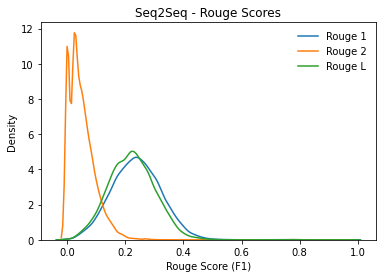

In [46]:
fig, ax = plt.subplots()
sns.kdeplot(result_s2s['rouge1'], label = 'Rouge 1', ax = ax)
sns.kdeplot(result_s2s['rouge2'], label = 'Rouge 2', ax = ax)
sns.kdeplot(result_s2s['rougeLsum'], label = 'Rouge L', ax = ax)
plt.legend(frameon = False)
plt.title('Seq2Seq - Rouge Scores')
x= plt.xlabel('Rouge Score (F1)')

In [47]:
### Saving for later uses ###

import pickle 
with open('/content/gdrive/MyDrive/NLP/rouge_scores_s2s.pkl','wb') as f :
  pickle.dump(result_s2s, f)
with open('/content/gdrive/MyDrive/NLP/summaries_s2s.pkl','wb') as f : 
  pickle.dump(rouge_s2s_summaries,f)

## Pretrained Model: BART Sum (abstractive)

In this part, we use facebook [pretrained BART model](https://huggingface.co/facebook/bart-large-cnn). This BART model was fine tuned to produce CNN/Daily Mail summaries. The original publication is available [here](https://arxiv.org/pdf/1910.13461.pdf). BART achieved in $2019$ state-of-the-art performances for this summarization task, gaining around $4$ ROUGE points when compared to the Lead-3 baseline (extractive) and around $2$ points when compared to previous state-of-the-art ([BERT Sum](https://arxiv.org/pdf/1908.08345.pdf)).

We use Huggingface API to load the pretrained model and perform inference on the test split of the CNN/DM dataset.

In [ ]:
import datasets
dataset = datasets.load_dataset("ccdv/cnn_dailymail", '3.0.0', split = 'test')
true_summaries = [i['highlights'] for i in dataset]

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/ccdv___cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f)


In [ ]:
!pip install transformers
import transformers
from transformers.pipelines.pt_utils import KeyDataset

#We build a summarization pipeline: based on the article, it will tokenize and pass it as input to the model.
summarizer = transformers.pipeline("summarization", model = "facebook/bart-large-cnn", device = 0)

In [ ]:
## INFERENCE ##

batch_size = 16
summaries = summarizer(KeyDataset(dataset, 'article'), batch_size = batch_size, max_length=100, do_sample=False, truncation = True)
test_summaries = []

for model_result in tqdm(summaries, total =dataset.num_rows) : 
  test_summaries.extend([i['summary_text'] for i in model_result])

100%|██████████| 11490/11490 [1:49:18<00:00,  1.75it/s]


In [ ]:
## CALCULATING ROUGE SCORES ##
from nltk.tokenize import sent_tokenize

rouge_test_summaries = ['\n'.join(sent_tokenize(i)) for i in tqdm(test_summaries, total = len(test_summaries))]
result_bart = get_rouge_scores(rouge_test_summaries, true_summaries)

100%|██████████| 11490/11490 [01:10<00:00, 162.15it/s]


In [106]:
print(f"(BART) Rouge 1: {np.mean(result_bart['rouge1']):0.3f}")
print(f"(BART) Rouge 2: {np.mean(result_bart['rouge2']):0.3}")
print(f"(BART) Rouge L: {np.mean(result_bart['rougeLsum']):0.3f}")


(BART) Rouge 1: 0.440
(BART) Rouge 2: 0.21
(BART) Rouge L: 0.408


We recovered the ROUGE scores from the original BART paper. 

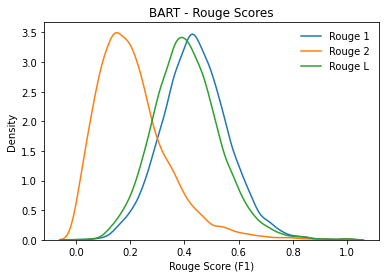

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(result_bart['rouge1'], label = 'Rouge 1', ax = ax)
sns.kdeplot(result_bart['rouge2'], label = 'Rouge 2', ax = ax)
sns.kdeplot(result_bart['rougeLsum'], label = 'Rouge L', ax = ax)
plt.legend(frameon = False)
plt.title('BART - Rouge Scores')
x= plt.xlabel('Rouge Score (F1)')

In [ ]:
### Saving for later uses ###

import pickle 
with open('/content/gdrive/MyDrive/NLP/rouge_scores_bart.pkl','wb') as f :
  pickle.dump(result_bart, f)
with open('/content/gdrive/MyDrive/NLP/summaries_bart.pkl','wb') as f : 
  pickle.dump(rouge_test_summaries,f)

## Analyzing predicted summaries

In [54]:
## Loading Summaries
if load: 
  with open('/content/gdrive/MyDrive/NLP/summaries_lead3.pkl','rb') as f : 
    lead3_sum = pickle.load(f)
  with open('/content/gdrive/MyDrive/NLP/summaries_s2s.pkl','rb') as f : 
    s2s_sum = pickle.load(f)
  with open('/content/gdrive/MyDrive/NLP/summaries_bart.pkl','rb') as f : 
    bart_sum = pickle.load(f)

  with open('/content/gdrive/MyDrive/NLP/rouge_scores_lead3.pkl','rb') as f : 
    lead3_scores = pickle.load(f)
  with open('/content/gdrive/MyDrive/NLP/rouge_scores_s2s.pkl','rb') as f : 
    s2s_scores = pickle.load(f)
  with open('/content/gdrive/MyDrive/NLP/rouge_scores_bart.pkl','rb') as f : 
    bart_scores = pickle.load(f)

  counts_test = pd.read_csv('/content/gdrive/MyDrive/NLP/test_counts.csv')

In [103]:
## Small Length Article
indices = counts_test[(counts_test['word_count_text']> 60) & (counts_test['word_count_text']< 65)  ].index.tolist()
idx = indices[0]

print('REFERENCE ARTICLE')
print(df_test['text_cleaned'][idx])
print('\nREFERENCE SUMMARY')
print(df_test['y'][idx])
print('\nLEAD-3 SUMMARY')
print(lead3_sum[idx])
print('\nSeq2Seq SUMMARY')
print(s2s_sum[idx])
print('\nBART SUMMARY')
print(bart_sum[idx])

print('\n')
print('\t\t ROUGE-1 \t ROUGE-2 \t ROUGE-L')
print(f'Lead-3\t\t {round(lead3_scores["rouge1"][idx],3)} \t\t {round(lead3_scores["rouge2"][idx],3)} \t\t {round(lead3_scores["rougeLsum"][idx],3)}')
print(f'Seq2Seq\t\t {round(s2s_scores["rouge1"][idx],3)} \t\t {round(s2s_scores["rouge2"][idx],3)} \t\t {round(s2s_scores["rougeLsum"][idx],3)}')
print(f'BART\t\t {round(bart_scores["rouge1"][idx],3)} \t\t {round(bart_scores["rouge2"][idx],3)} \t\t {round(bart_scores["rougeLsum"][idx],3)}')

REFERENCE ARTICLE
The build-up for the blockbuster fight between Floyd Mayweather and Manny Pacquiao in Las Vegas on May 2 steps up a gear on Tuesday night when the American holds an open workout for the media. The session will be streamed live across the world and you can watch it here from 12am UK (7pm EDT).

REFERENCE SUMMARY
Floyd Mayweather holds an open media workout from 12am UK (7pm EDT)
The American takes on Manny Pacquiao in Las Vegas on May 2 .
Mayweather's training is being streamed live across the world .

LEAD-3 SUMMARY
The build-up for the blockbuster fight between Floyd Mayweather and Manny Pacquiao in Las Vegas on May 2 steps up a gear on Tuesday night when the American holds an open workout for the media.
The session will be streamed live across the world and you can watch it here from 12am UK (7pm EDT).

Seq2Seq SUMMARY
Floyd Mayweather will be open to the fight on Tuesday night .
The fight will be open in Las Vegas .
Mayweather will be open to the fight Floyd Maywea

In [102]:
## Medium Length Article 


indices = counts_test[(counts_test['word_count_text']> 305) & (counts_test['word_count_text']< 310)  ].index.tolist()
idx = indices[0]

print('REFERENCE ARTICLE')
print(df_test['text_cleaned'][idx])
print('\nREFERENCE SUMMARY')
print(df_test['y'][idx])
print('\nLEAD-3 SUMMARY')
print(lead3_sum[idx])
print('\nSeq2Seq SUMMARY')
print(s2s_sum[idx])
print('\nBART SUMMARY')
print(bart_sum[idx])

print('\n')
print('\t\t ROUGE-1 \t ROUGE-2 \t ROUGE-L')
print(f'Lead-3\t\t {round(lead3_scores["rouge1"][idx],3)} \t\t {round(lead3_scores["rouge2"][idx],3)} \t\t {round(lead3_scores["rougeLsum"][idx],3)}')
print(f'Seq2Seq\t\t {round(s2s_scores["rouge1"][idx],3)} \t\t {round(s2s_scores["rouge2"][idx],3)} \t\t {round(s2s_scores["rougeLsum"][idx],3)}')
print(f'BART\t\t {round(bart_scores["rouge1"][idx],3)} \t\t {round(bart_scores["rouge2"][idx],3)} \t\t {round(bart_scores["rougeLsum"][idx],3)}')

REFERENCE ARTICLE
(CNN)A judge this week sentenced a former TSA agent to six months in jail for secretly videotaping a female co-worker while she was in the bathroom, prosecutors said. During the investigation, detectives with the Metro Nashville Police Department in Tennessee also found that the agent, 33-year-old Daniel Boykin, entered the woman's home multiple times, where he took videos, photos and other data. Police found more than 90 videos and 1,500 photos of the victim on Boykin's phone and computer. The victim filed a complaint after seeing images of herself on his phone last year. Boykin plead guilty to unlawful photography, aggravated burglary and violation of the computer act, the Nashville District Attorney's Office said. Police said the incident happened in a TSA-only restroom, and that there was no evidence public restrooms were targeted. A TSA official tells CNN that Boykin worked in an administrative capacity and didn't engage in public security screening. Assistant Di

In [104]:
## Poor Performance BART

array = np.array(bart_scores['rouge1'])
indices = np.argsort(abs(array - np.quantile(array, 0.05)))
subset = counts_test.loc[indices]
indices = subset[subset['word_count_text'] < 300].index.tolist()
idx = indices[0]

print('REFERENCE ARTICLE')
print(df_test['text_cleaned'][idx])
print('\nREFERENCE SUMMARY')
print(df_test['y'][idx])
print('\nLEAD-3 SUMMARY')
print(lead3_sum[idx])
print('\nSeq2Seq SUMMARY')
print(s2s_sum[idx])
print('\nBART SUMMARY')
print(bart_sum[idx])

print('\n')
print('\t\t ROUGE-1 \t ROUGE-2 \t ROUGE-L')
print(f'Lead-3\t\t {round(lead3_scores["rouge1"][idx],3)} \t\t {round(lead3_scores["rouge2"][idx],3)} \t\t {round(lead3_scores["rougeLsum"][idx],3)}')
print(f'Seq2Seq\t\t {round(s2s_scores["rouge1"][idx],3)} \t\t {round(s2s_scores["rouge2"][idx],3)} \t\t {round(s2s_scores["rougeLsum"][idx],3)}')
print(f'BART\t\t {round(bart_scores["rouge1"][idx],3)} \t\t {round(bart_scores["rouge2"][idx],3)} \t\t {round(bart_scores["rougeLsum"][idx],3)}')

REFERENCE ARTICLE
Saracens flanker Jacques Burger has been cited for alleged foul play during last Sunday's European Champions Cup quarter-final game against Racing Metro in Paris. European Professional Club Rugby said that Burger is alleged to have struck Racing scrum-half Maxime Machenaud midway through the match at Stade Yves-du-Manoir, which Saracens won 12-11. The complaint was made by match citing commissioner Eugene Ryan. Jacques Burger (right) arrives on the scene as Maxime Machenaud (left) prepare to play a diving pass. Burger then catches Machenaud after the ball has gone but the player was low to the floor. Namibia international Burger, 31, will face a disciplinary hearing on Thursday. Welshman Simon Thomas has been appointed as independent judicial officer. World Rugby's low end punishment for such an offence is a two-week ban, with anything from eight weeks to 52 weeks at the top end. Saracens return to Aviva Premiership action against play-off rivals Leicester on Saturday